In [70]:
from llama_index.legacy import (
    KeywordTableIndex,
    SimpleDirectoryReader,
    ServiceContext,
    StorageContext,
    download_loader,
    load_index_from_storage,
    VectorStoreIndex)

from llama_index.legacy.llms.vertex import Vertex
from langchain.chat_models import ChatVertexAI
from llama_index.legacy.llms.langchain import LangChainLLM
from langchain_google_vertexai import VertexAIEmbeddings
from llama_index.legacy.embeddings import LangchainEmbedding
from llama_index.legacy import Document
from llama_index.legacy.node_parser import SimpleNodeParser, HierarchicalNodeParser


from llama_index.legacy.vector_stores.chroma import ChromaVectorStore
import chromadb


from google.oauth2 import service_account
from llama_index.legacy import set_global_service_context
from google.cloud import aiplatform
import json 

## imports from og llama index file

In [71]:
from llama_index.legacy import VectorStoreIndex, SimpleDirectoryReader
from llama_index.legacy.embeddings import LangchainEmbedding
from llama_index.legacy.text_splitter import TokenTextSplitter
from langchain_google_vertexai import VertexAIEmbeddings
from llama_index.legacy.llms.vertex import Vertex
from llama_index.legacy.node_parser import SimpleNodeParser, HierarchicalNodeParser
from llama_index.legacy import (
    KeywordTableIndex,
    SimpleDirectoryReader,
    ServiceContext,
    StorageContext,
    download_loader,
    load_index_from_storage,
    VectorStoreIndex)
from llama_index.legacy.retrievers import VectorIndexRetriever
from llama_index.legacy.prompts import (
    ChatMessage,
    ChatPromptTemplate,
    MessageRole,
    PromptTemplate,
)

from llama_index.legacy.postprocessor import NERPIINodePostprocessor, SentenceEmbeddingOptimizer
from llama_index.legacy import ServiceContext
from llama_index.legacy.schema import QueryBundle
from llama_index.legacy.schema import NodeWithScore, TextNode

from pathlib import Path
from tqdm.notebook import tqdm
from google.oauth2 import service_account

from llama_index.legacy import set_global_service_context
import re
import uuid
import os
from pathlib import Path
from pprint import pprint
import pandas as pd
import csv
from typing import List, Tuple, Dict
import time
import json

from llama_index.legacy.vector_stores.chroma import ChromaVectorStore
from llama_index.legacy import StorageContext
from llama_index.legacy.embeddings.huggingface import HuggingFaceEmbedding
from IPython.display import Markdown, display
import chromadb
from llama_index.core import Settings

from llama_index.legacy.llms.langchain import LangChainLLM
from langchain_google_vertexai import ChatVertexAI
from llama_index.legacy import Response
from llama_index.legacy.response_synthesizers import Refine
from llama_index.legacy.evaluation import SemanticSimilarityEvaluator
from llama_index.legacy.evaluation import RelevancyEvaluator
from llama_index.legacy.embeddings import SimilarityMode

import nest_asyncio
nest_asyncio.apply()

# additional
from llama_index.legacy.postprocessor import LongContextReorder
from llama_index.legacy.retrievers import AutoMergingRetriever
from llama_index.legacy.query_engine import TransformQueryEngine
from llama_index.legacy.query_engine import RetrieverQueryEngine
from llama_index.legacy.indices.query.query_transform.base import (
    HyDEQueryTransform,StepDecomposeQueryTransform
)
from llama_index.legacy.node_parser import get_leaf_nodes
from llama_index.legacy import Document
# llama_debug = LlamaDebugHandler(print_trace_on_end=True)
# callback_manager = CallbackManager([llama_debug])

## Initialize credentials, models, and embedding models

In [72]:
import vertexai
from vertexai.language_models import TextGenerationModel
from langchain_google_vertexai.llms import VertexAI

credentials = service_account.Credentials.from_service_account_file("credentials/vertex-test-417403-ce72ad032af7.json")
vertex_ai = Vertex(model="text-bison", project=credentials.project_id, location= "asia-southeast1", credentials=credentials, temperature=0.2)
text_model = TextGenerationModel.from_pretrained("text-bison@002")
text_vertex_ai = VertexAI(model_name="text-bison@002", project=credentials.project_id, location= "asia-southeast1", credentials=credentials, temperature=0.2)                       
chat_vertex_ai = ChatVertexAI(model_name="chat-bison-32k", project=credentials.project_id, location= "asia-southeast1", credentials=credentials, temperature=0.2, max_output_tokens= 8192) # max for bison 32k
embed_model = LangchainEmbedding(VertexAIEmbeddings(model_name='textembedding-gecko-multilingual@latest'))

In [73]:
service_context = ServiceContext.from_defaults(llm=vertex_ai, embed_model=embed_model, chunk_size=1024, chunk_overlap=20)
set_global_service_context(service_context)
# need to set global service context becuase if not index = VectorStoreIndex.from_vector_store(vector_store, embed_model=Settings.embed_model) will produce an error
# it will say that it requires OPENAI key etc
service_context

ServiceContext(llm_predictor=LLMPredictor(system_prompt=None, query_wrapper_prompt=None, pydantic_program_mode=<PydanticProgramMode.DEFAULT: 'default'>), prompt_helper=PromptHelper(context_window=3900, num_output=256, chunk_overlap_ratio=0.1, chunk_size_limit=None, separator=' '), embed_model=LangchainEmbedding(model_name='textembedding-gecko-multilingual@latest', embed_batch_size=10, callback_manager=<llama_index.legacy.callbacks.base.CallbackManager object at 0x000001DA5CFCAA10>), transformations=[SentenceSplitter(include_metadata=True, include_prev_next_rel=True, callback_manager=<llama_index.legacy.callbacks.base.CallbackManager object at 0x000001DA5CFCAA10>, id_func=<function default_id_func at 0x000001DA4E7ED3A0>, chunk_size=1024, chunk_overlap=20, separator=' ', paragraph_separator='\n\n\n', secondary_chunking_regex='[^,.;。？！]+[,.;。？！]?')], llama_logger=<llama_index.legacy.logger.base.LlamaLogger object at 0x000001DA5FE4A510>, callback_manager=<llama_index.legacy.callbacks.base.

## {DONE} Produce csv storing query, model response (and soon others)

load query text files into one csv file

In [74]:
# import pandas as pd

# # Sample text strings (replace with your actual file paths)
# text_file1 = "../data/chief complaint.txt"
# text_file2 = "../data/making appointment.txt"
# text_file3 = "../data/medical experts.txt"

# # Create a list of text strings
# text_list = []
# for filename in [text_file1, text_file2, text_file3]:
#   with open(filename, "r") as f:
#     # Read all lines and concatenate them into a single string
#     text_content = f.readlines()  # Remove potential leading/trailing whitespace
#     text_list.extend(text_content)

# text_list = [line.replace('\n', '') for line in text_list]
# print(len(text_list))
# text_list

In [75]:
# # Create a DataFrame with a single column named "Text"
# # df = pd.DataFrame({"Text": text_list}, columns=["query"])
# df = pd.DataFrame(text_list, columns=["query"])

# filepath = "model_response.csv"
# df.to_csv(filepath, index=False)
# print(f"Data saved to {filepath}")

Create dataframe from model_response.csv file

In [76]:
filepath = "model_response.csv"
model_response_df = pd.read_csv(filepath)

,query
0,ถ้ามีอาการเจ็บหน้าอกและหอบหืดขณะออกกำลังกายควร...
1,ผมมีอาการท้องผูกและอาหารย่อยยากมานานหลายปีต้อง...
2,ผู้สูงวัยมีอาการปวดศีรษะรุนแรงและมีอาการคลื่นไ...
3,หมอแบบไหนที่ให้คำปรึกษาได้หากมีอาการท้องเสียรุ...
4,คลินิกด้านไหนที่รักษาอาการระบบทางเดินหายใจอักเ...
5,อยากตรวจหาสาเหตุของการเจ็บแสบหลังสะโพกและมีปัญ...
6,เด็กมีปัญหาการมองเห็นและมีปัญหาด้านสายตาต้องปร...
7,น้องสาวมีอาการตกขาวที่มีกลิ่นเหม็นและคันแต่อาย...
8,ลูกสาวมีอาการปวดท้องประจำเดือนและการมีรอยคราบเ...
9,อยากหาหมอที่ตรวจหาสาเหตุของอาการหัวใจเต้นเร็วแ...


## Import and load data
- How to create documents from a list of strings: 
https://docs.llamaindex.ai/en/stable/module_guides/loading/documents_and_nodes/usage_documents.html#defining-documents

### load data from siriraj_doctor_details.csv (given)

cleaning csv data

In [77]:
import pandas as pd

# unused
# reader = SimpleDirectoryReader(
#     input_files=["../data/siriraj_doctor_details.csv"]
# )
# csv_data = reader.load_data()
# print(f"Loaded {len(csv_data)} docs")
# csv_data

csv_file_path = "../data/siriraj_doctor_details.csv"
csv_df = pd.read_csv(csv_file_path)
columns_to_drop = ['image_src', 'url']
df = csv_df.drop(columns=[col for col in csv_df.columns if col in columns_to_drop])
df

,name,table_check,qualification,expertise
0,รศ. พญ.กติกา นวพันธุ์,"เสาร์ 14:00 - 17:00 น. สัปดาห์ที่ 1,2,3,4,5",แพทยศาสตรบัณฑิต คณะแพทยศาสตร์ จุฬาลงกรณ์มหาวิท...,เวชศาสตร์มารดาและทารกในครรภ์
1,รศ. พญ.กนกรัตน์ พรพาณิชย์,"พุธ 08:00 - 11:15 น. สัปดาห์ที่ 1,2,3,4,5",การถนอมสายตา,ศัลยกรรมกระดูกเบ้าตาและตกแต่ง
2,อ. พญ.กนกรัตน์ สุวรรณสิทธิ์,"พฤหัสบดี 13:30 - 17:00 น. สัปดาห์ที่ 1,2,3,4,5",แพทยศาสตรบัณฑิต คณะแพทยศาสตร์ศิริราชพยาบาล มหา...,โสต ประสาท การได้ยินและการทรงตัว
3,ทพญ.กนกอร ตันติพาณิชย์กูล,"พุธ 16:30 - 19:30 น. สัปดาห์ที่ 3,4",ทันตแพทยศาสตร์บัณฑิต คณะทันตแพทยศาสตร์ มหาวิทย...,ทันตกรรมจัดฟัน การจัดฟันด้วยการผ่าตัดจัดฟัน
4,ผศ. นพ.กมล เผือกเพ็ชร,"พุธ 16:00 - 18:00 น. สัปดาห์ที่ 1,3,5 อาทิตย์ ...",โรคมือ เท้า ปาก(hand-foot-and-mouth disease),กุมารเวชศาสตร์โลหิตวิทยาและมะเร็งในเด็ก
...,...,...,...,...
625,นพ.เอกราช ลิ่วธนมงคล,"เสาร์ 09:00 - 11:00 น. สัปดาห์ที่ 1,2,3,4,5 13...",แพทยศาสตรบัณฑิต คณะแพทยศาสตร์ศิริราชพยาบาล มหา...,"โรคของลำไส้ใหญ่และทวารหนัก, ฝีคัณฑสูตร, ริดสีด..."
626,รศ. นพ.เอกรินทร์ โชติกวาณิชย์,"พุธ 13:00 - 13:30 น. สัปดาห์ที่ 1,2,3,4,5 เสาร...",ปัสสาวะบ่อย ปัสสาวะขัดกระเพาะปัสสาวะอักเสบหรือ...,"โรคนิ่วไต ท่อไต และกระเพาะปัสสาวะ, โรคเนื้องอก..."
627,อ. นพ.เอกวิทย์ เกยุราพันธุ์,"ศุกร์ 09:00 - 11:00 น. สัปดาห์ที่ 1,2,3,4,5 อา...",NaN,ศัลยศาสตร์ออร์โธปิดิกส์
628,นพ.เอนกชัย ดกพฤกษ์,NaN,เฝ้าระวังศีรษะกระแทก 72 ชั่วโมง,เวชศาสตร์ฉุกเฉิน


### TODO: Cluster expertise (not done)
- not sure if needed atm. will be used as a point of improvement later

The expertise strings are varied so should group them into better categories for better retrieval and structuring

reduce the expertise types into limited categories so that can later restructure data retrieval to be some kind of tree structure for finding doctors according to expertise more effectively

In [78]:
import numpy as np

expertises = df["expertise"]
all_expertise_list = []
for i in expertises:
    j = i.split(",")
    all_expertise_list.extend(j)
all_expertise_list  

expertise_list = np.unique(all_expertise_list).tolist()
print(expertise_list)  # Output: [1, 2, 3, 4, 5]
print(len(expertise_list))

[' Allergy and Immunology)', ' Arthroplasty', ' General rehabilitation', ' Geriatric psychiatry (จิตเวชผู้สูงอายุ)', ' MIS', ' Multiple myeloma', ' Neurological rehabilitation', ' PEG', ' Sport Medicine and Arthroscopic Surgery', ' Upper GI surgery', ' Wrist and Elbow surgery', ' laparoscopic surgery)', ' การฉีดสี และลิ้นหัวใจตีบด้วยการถ่างขยายด้วยบอลลูน', ' การฉีดสีและถ่างขยายหลอดเลือดหัวใจ', ' การฉีดสีและถ่างขยายหลอดเลือดหัวใจและหลอดเลือดส่วนปลาย', ' การดูแลแบบประคับประคอง', ' การผ่าตัดด้วยหุ่นยนต์', ' การผ่าตัดน้ำวุ้นตา', ' การผ่าตัดผ่านกล้องทางนรีเวช', ' การผ่าตัดลำไส้ด้วยการส่องกล้องผ่านผนังหน้าท้อง', ' การฟื้นฟูการดูดกลื่น', ' การฟื้นฟูด้านของเล่นบำบัด', ' การฟื้นฟูพัฒนาการทางการมองเห็นในเด็ก', ' การฟื้นฟูสมรรถภาพผู้สูงอายุ', ' การฟื้นฟูอาการบาดเจ็บที่ไขสันหลัง', ' การฟื้นฟูเด็กกลุ่มเสี่ยงต่อความพิการ', ' การรักษาด้วยรังสีร่างกาย Stereotactic (SBRT)', ' การรักษาด้วยโปรตอน', ' การรักษาริ้วรอยด้วยสารโบท็อกซ์และสารเติมเต็ม (Filler)', ' การส่องกล้องกระเพาะอาหาร ลำไส้ใหญ่และลำไส้เล็ก'

373


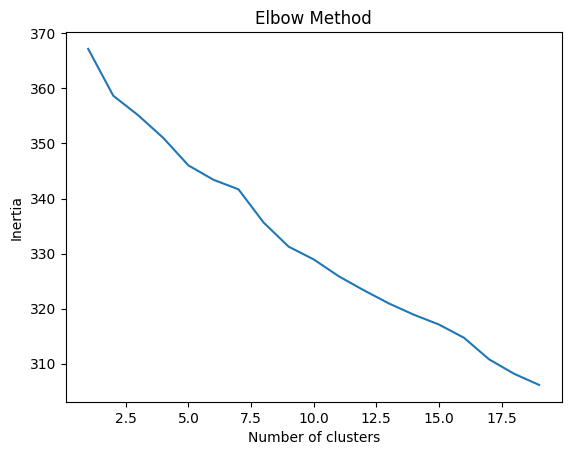

Cluster 5:
- 
- adult reconstructive surgery
- allergy immunology 
- arthroplasty
- cardiac imagimg
- general rehabilitation
- geriatric psychiatry  จิตเวชผู้สูงอายุ 
- hand microsurgery
- hematologic malignancy
- internal medicine medical oncology cancer biology
- lap hernioplasty
- laparoscopic surgery 
- minimally invasive surgery
- mis
- mood disorder  ซึมเศร้า
- multiple myeloma
- musculoskeletal pain management
- neurological rehabilitation
- oncology
- peg
- rhinology allergy
- sport medicine arthroscopic surgery
- upper gi surgery
- vascular surgery
- wrist elbow surgery
- กระจกตา และ แก้ไขสายตาด้วยเลเซอร์ เลสิก
- กล่องเสียง
- การฉายแสงอาทิตย์เทียม
- การดูแลปอดและวิกฤต
- การดูแลแบบประคับประคอง
- การตรวจวิเคราะห์วงจรไฟฟ้าในหัวใจด้วยการสวนหัวใจ
- การตรวจหัวใจด้วยเครื่องคลื่นแม่เหล็กไฟฟ้าและเอ็กซเรย์คอมพิวเตอร์
- การตรวจหัวใจและหลอดเลือดหัวใจด้วยเครื่องตรวจสนามแม่เหล็กไฟฟ้าและการตรวจวิเคราะห์วงจรไฟฟ้าในหัวใจด้วยการสวนหัวใจ
- การบาดเจ็บ ศัลยกรรมตกแต่งและเสริมสร้าง
- การบาดเจ็บของเส

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import matplotlib.pyplot as plt

def preprocess_text(text):
  text = text.lower()
  stop_words = set(stopwords.words('english'))
  text = ' '.join([word for word in word_tokenize(text) if word not in stop_words])
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = text.lower()
  return text

expertise_list = [preprocess_text(text) for text in expertise_list]
expertise_list = np.unique(expertise_list).tolist() # remove duplicates
print(len(expertise_list))

# Feature Extraction (using TF-IDF)
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(expertise_list)

# Determine the optimal number of clusters (using elbow method)
# (replace with more sophisticated methods if needed)
from sklearn.metrics import silhouette_score

inertia = []
for k in range(1, 20):  # Adjust range for desired number of clusters
  kmeans = KMeans(n_clusters=k, random_state=0)
  kmeans.fit(features)
  inertia.append(kmeans.inertia_)

# Plot the elbow curve to visualize the optimal number of clusters (optional)
plt.plot(range(1, 20), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Choose the optimal number of clusters (e.g., based on elbow curve)
optimal_k = 10  # Replace with your chosen value

# Perform K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans.fit(features)

# Group expertise names based on cluster labels
clustered_expertise = {}
for i, expertise in enumerate(expertise_list):
  cluster = kmeans.labels_[i]
  if cluster not in clustered_expertise:
    clustered_expertise[cluster] = []
  clustered_expertise[cluster].append(expertise)

# Print the clustered expertise
for cluster, expertise_group in clustered_expertise.items():
  print(f"Cluster {cluster+1}:")
  for expertise in expertise_group:
    print(f"- {expertise}")
  print("...")


In [80]:
# from sentence_transformers import SentenceTransformer
# import scipy
# def preprocess_text(text):
#   text = text.lower()
#   stop_words = set(stopwords.words('english'))
#   text = ' '.join([word for word in word_tokenize(text) if word not in stop_words])
#   text = text.translate(str.maketrans('', '', string.punctuation))
#   text = text.lower()
#   return text

# expertise_list = [preprocess_text(text) for text in expertise_list]
# expertise_list = np.unique(expertise_list).tolist() # remove duplicates
# print(len(expertise_list))

# # Load pre-trained sentence transformer model (e.g., all-mpnet-base-v2)
# model = SentenceTransformer('all-mpnet-base-v2')

# # Embed each expertise using the sentence transformer
# embeddings = model.encode(expertise_list)

# # Define a custom distance function (consider Word Mover's Distance or cosine similarity)
# def custom_distance(emb1, emb2):
#   # Replace with a more sophisticated similarity metric (e.g., Word Mover's Distance)
#   return SentenceTransformer.util.pytorch_cos_sim(emb1, emb2).squeeze(0)

# # Perform hierarchical clustering using the custom distance function
# from scipy.cluster.hierarchy import linkage, dendrogram

# distance_matrix = np.zeros((len(expertise_list), len(expertise_list)))
# for i in range(len(expertise_list)):
#   for j in range(i + 1, len(expertise_list)):
#     distance_matrix[i, j] = custom_distance(embeddings[i], embeddings[j])

# # Cluster using Ward's method (adjust method if needed)
# Z = linkage(distance_matrix, method='ward')

# # (Optional) Visualize the clustering hierarchy using a dendrogram
# # ...

# # Choose the desired level of granularity for clusters (based on dendrogram or metrics)
# cut_off_distance = 0.7  # Adjust threshold based on your analysis

# # Extract cluster labels for each expertise
# cluster_labels = scipy.cluster.hierarchy.fcluster(Z, cut_off_distance, criterion='distance')

# # Create a DataFrame with expertise and cluster labels
# df = pd.DataFrame({'Expertise': expertise_list, 'Cluster': cluster_labels})

# # Print the clustered expertise
# print(df.groupby('Cluster')['Expertise'].apply(list))

--- unused category splitting code

In [81]:
# def split_expertise(data):
#   """
#   Splits a single string of expertise into separate rows for each expertise.

#   Args:
#       data: A dictionary with doctor name and expertise string (e.g., from a row in the DataFrame)

#   Returns:
#       A list of dictionaries, each with doctor name and a single expertise value.
#   """
#   doctor_name = data["name"]
#   print(type(data["expertise"]))
#   expertises = data["expertise"].split(",")  # Replace ";" with your delimiter if different
#   return [{'name': doctor_name, 'expertise': expertise.strip()} for expertise in expertises]

# new_df = split_expertise(df)


In [82]:
# import pandas
# # import Series, DataFrame  # Explicit imports for clarity


# def split_expertise(df):
#   """
#   Splits expertise from a pandas Series into separate rows for each expertise.

#   Args:
#       expertise_series: A pandas Series containing expertise data (e.g., from a DataFrame column)

#   Returns:
#       A list of dictionaries, each with doctor name and a single expertise value.
#   """
#   doctor_names = df["name"]  # Assuming doctor name is in a separate column
#   expertises = df["expertise"]
#   return [{'Doctor Name': name, 'Expertise': expertise.strip()} 
#           for name, expertise in zip(doctor_names, expertises.str.split(","))]  # Replace ";" with your delimiter if different


# new_df = split_expertise(df)


# # # Explode the DataFrame based on expertise
# # df_exploded = df.assign(Expertise=df["Expertise"].str.split(";").explode())  # Split and expand

# # # Group doctors by expertise (assuming expertise is now a list in each row)
# # doctors_by_expertise = df_exploded.groupby("Expertise")["Doctor Name"].unique().reset_index()


In [83]:
# # Explode the DataFrame based on expertise
# df_exploded = df.explode("expertise", expand=True) if "expertise" in df.columns else df

# doctors_by_expertise = df_exploded.groupby("expertise")["name"].unique().reset_index()
# expertise_to_doctors = df_exploded.groupby("expertise")["name"].apply(list).to_dict()


In [84]:
csv_data = df.apply(lambda x: ''.join(x.astype(str)), axis=1).tolist()
csv_data = [Document(text=t) for t in csv_data]
print(len(csv_data))
print(csv_data)

630
[Document(id_='99a0d601-d786-45f9-a0f2-eec3f748ccd1', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='รศ. พญ.กติกา นวพันธุ์เสาร์ 14:00 - 17:00 น. สัปดาห์ที่ 1,2,3,4,5แพทยศาสตรบัณฑิต คณะแพทยศาสตร์ จุฬาลงกรณ์มหาวิทยาลัย พ.ศ.2544วุฒิบัตรผู้เชี่ยวชาญเฉพาะทางสาขาสูติศาสตร์และนรีเวชวิทยา จุฬาลงกรณ์มหาวิทยาลัย พ.ศ.2550วุฒิบัตรผู้เชี่ยวชาญเฉพาะทางสาขาเวชศาสตร์มารดาและทารกในครรภ์ คณะแพทยศาสตร์ศิริราชพยาบาล มหาวิทยาลัยมหิดล พ.ศ.2552Certificate in Fetal Intervention, University Hospital, Leuven, KU Leuven, Belgium (Research Fellow)พ.ศ.2557เวชศาสตร์มารดาและทารกในครรภ์', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), Document(id_='346b1308-8254-48a3-902a-265ae0133b1a', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='รศ. พญ.กนกรัตน์ พรพาณิชย์พุธ 08:00 - 11:15 น.

### load baby_0_3.json data (given)

In [85]:
json_file = "../data/jsons/baby_0_3.json"
with open(json_file, 'r') as f:
    json_data = json.load(f)
    
# print("the number of documents: " , len(json_data))
# for i in json_data:
#     print(i) # str

How to create documents from a list of strings: 
https://docs.llamaindex.ai/en/stable/module_guides/loading/documents_and_nodes/usage_documents.html#defining-documents

In [86]:
from llama_index.legacy import Document
json_file = "../data/jsons/baby_0_3.json"
with open(json_file, 'r') as f:
    json_data = json.load(f)

# inspecting json data
# print("the number of documents: " , len(json_data))
# for i in json_data:
#     print(i) # str
    
docs = [Document(text=t) for t in json_data]
print(len(docs))
print(docs)

101
[Document(id_='a99aa60b-8750-4fca-96ea-3147ed4bcd24', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='1 คู่มือสําหรับพ่อแม่ เพื่อเผยแพร่ความรู\uf70bด\uf70bานการดูแลและพัฒนาเด็ก วัยเด็กเล็ก 0-3 ป\uf702 ตอน', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), Document(id_='60cbfb30-3806-4dcf-9b4d-e366dbe525e1', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='2 คู่มือสำหรับพ่อแม่ เพื่อเผยแพร่ควำมรู้ด้ำนกำรดูแลและพัฒนำเด็ก ตอน วัยเด็กเล็ก 0-3 ปี ทีมบรรณาธิการ พญ.นัยนา ณีศะนันท์ พญ.จริยา ทะรักษา รศ.นพ.วีระศักดิ์ ชลไชยะ คณะอนุกรรมการ Child Health Supervision รศ.พญ.ประสบศรี อึ้งถาวร พญ.วันดี นิงสานนท์ ศ.คลินิก พญ.วินัดดา ปิยะศิลป์ รศ.พญ.จันท์ฑิตา พฤกษานานนท์ รศ.นพ.อดิศักดิ์ ผลิตผลการพิมพ์ รศ.นพ.พงษ์ศักดิ์ น้อยพยัคฆ์ ผศ.(พิเศษ)นพ.เทอดพงศ์ เต็มภาคย์ ISBN จัดพิม

In [87]:
docs.extend(csv_data)
print(len(docs))
print(docs)

731
[Document(id_='a99aa60b-8750-4fca-96ea-3147ed4bcd24', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='1 คู่มือสําหรับพ่อแม่ เพื่อเผยแพร่ความรู\uf70bด\uf70bานการดูแลและพัฒนาเด็ก วัยเด็กเล็ก 0-3 ป\uf702 ตอน', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), Document(id_='60cbfb30-3806-4dcf-9b4d-e366dbe525e1', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='2 คู่มือสำหรับพ่อแม่ เพื่อเผยแพร่ควำมรู้ด้ำนกำรดูแลและพัฒนำเด็ก ตอน วัยเด็กเล็ก 0-3 ปี ทีมบรรณาธิการ พญ.นัยนา ณีศะนันท์ พญ.จริยา ทะรักษา รศ.นพ.วีระศักดิ์ ชลไชยะ คณะอนุกรรมการ Child Health Supervision รศ.พญ.ประสบศรี อึ้งถาวร พญ.วันดี นิงสานนท์ ศ.คลินิก พญ.วินัดดา ปิยะศิลป์ รศ.พญ.จันท์ฑิตา พฤกษานานนท์ รศ.นพ.อดิศักดิ์ ผลิตผลการพิมพ์ รศ.นพ.พงษ์ศักดิ์ น้อยพยัคฆ์ ผศ.(พิเศษ)นพ.เทอดพงศ์ เต็มภาคย์ ISBN จัดพิม

### load แนวทางการตรวจสุขภาพที่จำเป็นแหละเหมาะสม ฉบับปรับปรุง 2565 data (external)

In [123]:
def clean_text(text: str):
    """Clean parsed text from PDF for embedding"""
    text = text.replace("\uf70a", "่")
    text = text.replace("�ำ", "ำ")
    text = text.replace("�า", "ำ")
    return text

def convert_page_to_chunk(page_text, chunk_size: int = 2048):
    chunks = [page_text[i:i + chunk_size] for i in range(0, len(page_text), chunk_size)]
    return chunks

In [134]:
from tika import parser
parsed_book = parser.from_file("../data/pdfs/แนวทางการตรวจสุขภาพที่จำเป็นแหละเหมาะสม ฉบับปรับปรุง 2565.pdf")

n_pages = int(parsed_book["metadata"]["xmpTPg:NPages"])
print(n_pages)

125


In [135]:
content = parsed_book["content"]
content

'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nแนวทาง\nการตรวจสุขภาพ\nที่จำเป\uf712นและเหมาะสมสำหรับประชาชน\n\nฉบับปรับปรุง ๒๕๖๕\n\nแนวทางการตรวจสุขภาพ\n ที่จำเป\uf712นและเหมาะสมสำหรับประชาชน ฉบับปรับปรุง \n\nแนวทาง\nการตรวจสุขภาพ\nที่จำเป\uf712นและเหมาะสมสำหรับประชาชน\n\nฉบับปรับปรุง ๒๕๖๕\nกรมการแพทย์\n\nDEPARTMENT OF MEDICAL SERVICES\n\n\n\n2\n\nแนวทางการตรวจสุขภาพที่จ�าเป็นและเหมาะสมส�าหรับประชาชน\n\nISBN (E-Book): 978-974-422-980-9\n\nจัดท�ำและเผยแพร่โดย\n\nสถาบันวิจัยและประเมินเทคโนโลยีทางการแพทย์ กรมการแพทย์ กระทรวงสาธารณสุข \n\n\t จัดพิมพ์และเผยแพร่\n\n\t สถำบันวิจัยและประเมินเทคโนโลยีทำงกำรแพทย์\tกรมกำรแพทย์\n\n\t กระทรวงสำธำรณสุข\tถ.ติวำนนท์\tอ.เมือง\tจ.นนทบุรี\t11000\n\n\t โทรศัพท์\t0\t2590\t6394\t\n\n\t โทรสำร\t0\t2590\t8251\n\n\t http://www.dms.moph.go.th/imrta\n\nออกแบบจัดรูปเล่มโดย\n\nห้ำงหุ้นส่วนจ�ำกัด\tเพนตำกอน\tแอ็ดเวอร์ไทซิ่ง\n\n566/124\tซอยกิจพำนิช\tถนนพระรำม\t4\tแขวงมหำพฤฒำรำม\tเขตบำงรัก\tกรุงเทพฯ\t10500\n\n\n\n3\n\nแนวทำงฉบับนี้เ

In [117]:
content = parsed_book["content"]
content_processed = clean_text(content)
pages = content_processed.split("\n\n\n\n")
pages_strip = [" ".join(page.split()) for page in pages]  # strip extra spaces from page

chunks = []
for text in pages_strip:
    chunks.extend(convert_page_to_chunk(text))

len(chunks)

In [119]:
import json

with open("../data/jsons/แนวทางการตรวจสุขภาพที่จำเป็นแหละเหมาะสม ฉบับปรับปรุง 2565.json", "w") as f:
    json.dump(chunks, f, indent=4, ensure_ascii=False)

### load ตำราการตรวจรักษาโรคทั่วไป data (external)

In [140]:
parsed_book = parser.from_file("../data/pdfs/คู่มือโรคติดต่อทั่วไปเล่ม1.pdf")

n_pages = int(parsed_book["metadata"]["xmpTPg:NPages"])
print(n_pages)

197


In [141]:
content = parsed_book["content"]
content

'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n“คู\uf70aมือโรคติดต\uf70aอท่ัวไป”\n\nI I\n\nบรรณาธกิาร\nนายแพทย\uf70eวินัย วุตติวิโรจน\uf70e กลุ\uf70aมโรคติดต\uf70aอระหว\uf70aางประเทศ\n\nรองบรรณาธกิาร\nแพทย\uf70eหญิงวราลักษณ\uf70e ตังคณะกุล ผู\uf70bช\uf70aวยผู\uf70bอำนวยการสำนักโรคติดต\uf70aอทั่วไป\n\nที่ปรึกษา\nนายแพทย\uf70eสุชาติ เจตนเสน ที่ปรึกษาองค\uf70eการอนามัยโลก\nนายแพทย\uf70eศุภมิตร ชุณห\uf70eสุทธิวัฒน\uf70e ผู\uf70bทรงคุณวุฒิ กรมควบคุมโรค\nนายแพทย\uf70eศิริศักด์ิ วรินทราวาท รองอธิบดี กรมควบคุมโรค\nนายโอภาส การย\uf70eกวินพงศ\uf70e ผู\uf70bอำนวยการสำนักโรคติดต\uf70aอทั่วไป\n\nISBN : 978-974-297-884-6\nจัดพิมพ\uf70eโดย : สำนักโรคติดต\uf70aอทั่วไป กรมควบคุมโรค\nพิมพ\uf70eคร้ังท่ี : 1\nป\uf702ที่พิมพ\uf70e : 2551\nออกแบบและพิมพ\uf70eที่ : โรงพิมพ\uf70eชุมนุมสหกรณ\uf70eการเกษตรแห\uf70aงประเทศไทย\nจำนวน : 5,000 เล\uf70aม\n\n\n\nคู\uf70aมือโรคติดต\uf70aอท่ัวไป\n\nControl of Communicable Diseases in Manual 18th Edifion\nEdited by David L. Heymann\n\nสำนักโรคติดต\u

In [142]:
content_processed = clean_text(content)
pages = content_processed.split("\n\n\n\n")
pages_strip = [" ".join(page.split()) for page in pages]  # strip extra spaces from page

chunks = []
for text in pages_strip:
    chunks.extend(convert_page_to_chunk(text))

len(chunks)

322

In [ ]:
import json

with open("../data/jsons/คู่มือโรคติดต่อทั่วไปเล่ม1.json", "w") as f:
    json.dump(chunks, f, indent=4, ensure_ascii=False)

### Create local ChromaDB Vectore Store (currently unused)

In [88]:
# # Create index and persist to Chroma vector store

# db = chromadb.PersistentClient(path="chroma_db")
# chroma_collection = db.get_or_create_collection("chroma_db")
# vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
# storage_context = StorageContext.from_defaults(vector_store=vector_store)

# index = VectorStoreIndex.from_documents(
#     documents = docs, storage_context=storage_context, embed_model=embed_model
# )

In [89]:
# Load index from persisted vector store

# currently index is used for retriever and not query engine
db = chromadb.PersistentClient(path="chroma_db")
chroma_collection = db.get_or_create_collection("chroma_db")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
chromadb_index = VectorStoreIndex.from_vector_store(vector_store, embed_model=embed_model)

chromadb_query_engine = chromadb_index.as_query_engine(similarity_top_k=2)
vector_retriever = chromadb_index.as_retriever(similarity_top_k=2)

### Configuring query engine components

Hierarchical Node Parsing

In [90]:
# node_parser = HierarchicalNodeParser.from_defaults(
#     chunk_sizes=[1024, 512, 256]
# )
# nodes = node_parser.get_nodes_from_documents(docs)

# leaf_nodes = get_leaf_nodes(nodes)
# nodes_by_id = {node.node_id: node for node in nodes}

In [91]:
# auto_merging_context = ServiceContext.from_defaults(
#     llm=LangChainLLM(ChatVertexAI(model_name="chat-bison@002",
#                                          temperature=0.2,
#                                          max_output_tokens=256)
#                                          ),
#     embed_model= LangchainEmbedding(VertexAIEmbeddings(model_name='textembedding-gecko-multilingual@latest')),
#     node_parser=node_parser,
# )

In [92]:
# storage_context = StorageContext.from_defaults()
# storage_context.docstore.add_documents(nodes)

# leaf_nodes = get_leaf_nodes(nodes)
# nodes_by_id = {node.node_id: node for node in nodes}

# auto_merging_context = ServiceContext.from_defaults(
#     llm=selected_model,
#     embed_model= embed_model,
#     node_parser=node_parser,
# )

Store configured components in vector store called merging_index

In [93]:
# storage_context = StorageContext.from_defaults()
# storage_context.docstore.add_documents(nodes)

# automerging_index = VectorStoreIndex(leaf_nodes, storage_context=storage_context, service_context=auto_merging_context)
# # TODO: fix the code to store in chromadb
# # currently chromadb is not used

# merging_index_dir = "./merging_index"
# automerging_index.storage_context.persist(persist_dir=merging_index_dir)

Load automerging index

In [94]:
merging_index_dir = "./merging_index"
loaded_storage_context = StorageContext.from_defaults(persist_dir=merging_index_dir) # load the existing index
automerging_index = load_index_from_storage(loaded_storage_context)

In [95]:
automerging_as_retriever = automerging_index.as_retriever(similarity_top_k=10)
automerging_retriever = AutoMergingRetriever(
    automerging_as_retriever, 
    automerging_index.storage_context, 
    verbose=True
)

### Query engine

In [96]:
reorder = LongContextReorder()
hyde = HyDEQueryTransform(llm=vertex_ai, include_original=True)
retriever_query_engine = RetrieverQueryEngine.from_args(automerging_retriever,
                                              node_postprocessors=[reorder],
                                              )
transform_query_engine = TransformQueryEngine(retriever_query_engine, query_transform=hyde)

TESTING: Response production

In [97]:
query = "ถ้ามีอาการเจ็บหน้าอกและหอบหืดขณะออกกำลังกายควรปรึกษาแพทย์ด้านใด"
response=transform_query_engine.query(query)
print("response: ", response.response)
# print("source nodes: ", response.source_nodes[0])
# print("source node text: ", response.source_nodes[0].node.text)
# print("number of source nodes: ", len(response.source_node))

> Merging 1 nodes into parent node.
> Parent node id: 27881fca-bc6b-48e9-bb74-599c8dc3e2f2.
> Parent node text: รศ. นพ.ชุณหเกษม   โชตินัยวัตรกุลอังคาร 09:00 - 12:00 น. สัปดาห์ที่ 1,2,3,4,5 13:00 - 16:00 น. สัป...

> Merging 1 nodes into parent node.
> Parent node id: 6cb6f748-779c-41f7-82a7-0da01c667512.
> Parent node text: รศ. นพ.เอกรินทร์ โชติกวาณิชย์พุธ 13:00 - 13:30 น. สัปดาห์ที่ 1,2,3,4,5 เสาร์ 09:00 - 12:00 น. สัป...

> Merging 1 nodes into parent node.
> Parent node id: 8158531f-e944-4480-af35-45cfe36d694e.
> Parent node text: รศ. นพ.สัชชนะ พุ่มพฤกษ์พุธ 13:00 - 14:30 น. สัปดาห์ที่ 1,2,3,4,5 อาทิตย์ 13:00 - 14:30 น. สัปดาห์...

> Merging 1 nodes into parent node.
> Parent node id: ea5df51b-34ef-476f-8d6b-b8c9b498ab87.
> Parent node text: อ. พญ.ชลัยรัชฎ์ สุขอวยชัยnanปัสสาวะบ่อย ปัสสาวะขัดกระเพาะปัสสาวะอักเสบหรือเปล่า?ศัลยศาสตร์ยูโร

> Merging 1 nodes into parent node.
> Parent node id: b6d718de-edae-40df-bc3f-0f7c7a906d11.
> Parent node text: รศ. นพ.ชุณหเกษม   โชตินัยวัตรกุลอังคาร

Inspecting response and context nodes

In [98]:
response.response

' ข้อมูลที่ให้มาไม่มีคำตอบสำหรับคำถามนี้'

In [99]:
print(response.source_nodes[0])

Node ID: 31f3e0aa-13cf-4b2b-9fef-4abd757d8d69
Text: โรคบางอย่างท่ีนำมาด้วยอาการท้องผูก
เช่นโรคที่มีไทรอยด์ฮอร์โมนต�่า เด็กมักมีปัญหา พัฒนาการช้าร่วมด้วย ฯลฯ
หากสงสัยโรคดังกล่าวควรพาลูกไปพบแพทย์ วิธีการแก้ไข 1.
Score:  0.744



In [100]:
response.source_nodes[0].node.text

'โรคบางอย่างท่ีนำมาด้วยอาการท้องผูก เช่นโรคที่มีไทรอยด์ฮอร์โมนต�่า เด็กมักมีปัญหา พัฒนาการช้าร่วมด้วย ฯลฯ หากสงสัยโรคดังกล่าวควรพาลูกไปพบแพทย์ วิธีการแก้ไข 1.'

In [101]:
len(response.source_nodes)

10

Context Transformations - PII Example
- adding context to model response generation

In [102]:
pii_processor = NERPIINodePostprocessor()

def filter_pii_fn(**kwargs):
    # run optimizer
    query_bundle = QueryBundle(query_str=kwargs["query_str"])

    new_nodes = pii_processor.postprocess_nodes(
        [NodeWithScore(node=TextNode(text=kwargs["context_str"]))],
        query_bundle=query_bundle,
    )
    new_node = new_nodes[0]
    return new_node.get_content()

In [103]:
qa_prompt_tmpl_str = (
    "Context information is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "If you need to state yes or no, state it in Thai only\n"
    "If the question is a yes/no question, answer either yes or no in Thai before giving your reasoning for the answer.\n"
    "The reasoning should contain the relevant information and be concise if possible. Don't reiterate the same information twice.\n"
    "If the question asks about the date and time for an apppointment, answer in the following format only.\n"
    "(day) (time) (full name of doctor) (doctor's expertise)\n"
    "for example: วันจันทร์ เวลา 09:00 - 13:00 น. doctor: รศ. พญ.กติกา นวพันธุ์ expertise: เวชศาสตร์ฟื้นฟู \n" 
    "Also, the format of the answer should be as similar to the format in the context information as possible. This includes numbering order and indentation. \n"
    "The answer should not include the name of the document where the information is gotten from.\n"
    # "However, if the context information does not contain the answer for the query, answer เอกสารไม่มีระบุไว้\n"
    "Query: {query_str}\n"
    "Answer: "
)

qa_prompt_tmpl_str2 = (
    "Context information is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "If you need to state yes or no, state it in Thai only\n"
    "If the question is a yes/no question, answer either yes or no in Thai before giving your reasoning for the answer.\n"
    "The reasoning should contain the relevant information and be concise if possible. Don't reiterate the same information twice.\n"
    "If the question asks about the date and time for an apppointment, answer in the following format only.\n"
    "{day_time} {full_name} ({expertise})\n"
    "for example: วันจันทร์ เวลา 09:00 - 13:00 น. doctor: รศ. พญ.กติกา นวพันธุ์ expertise: เวชศาสตร์ฟื้นฟู \n" 
    "Also, the format of the answer should be as similar to the format in the context information as possible. This includes numbering order and indentation. \n"
    "The answer should not include the name of the document where the information is gotten from.\n"
    "However, if the context information does not contain the answer for the query, answer เอกสารไม่มีระบุไว้\n"
    "Query: {query_str}\n"
    "Answer: "
    "1. {day_time} {full_name} ({expertise})\n"
    "2. {day_time} {full_name} ({expertise})\n"
    "..."
)

In [104]:
import llama_index.legacy.response_synthesizers

qa_prompt_tmpl = PromptTemplate(
    qa_prompt_tmpl_str2, function_mappings={"context_str": filter_pii_fn}
)


prompts_dict = transform_query_engine.get_prompts()
print(list(prompts_dict.keys()))

transform_query_engine.update_prompts(
    {"query_engine:response_synthesizers": qa_prompt_tmpl}
) # use merging index


['query_transform:hyde_prompt', 'query_engine:response_synthesizer:text_qa_template', 'query_engine:response_synthesizer:refine_template']


### Produce dataframe containing query, model response, and context

In [105]:
def produce_response(query):
    # response = chromadb_query_engine.query(query)
    response = transform_query_engine.query(query)
    return response

def produce_context(query):
    # retrieved_nodes = vector_retriever.retrieve(query)
    retrieved_nodes = automerging_retriever.retrieve(query)
    context_str = "\n\n".join([n.get_content() for n in retrieved_nodes])
    return context_str

In [106]:
model_response_df

,query
0,ถ้ามีอาการเจ็บหน้าอกและหอบหืดขณะออกกำลังกายควร...
1,ผมมีอาการท้องผูกและอาหารย่อยยากมานานหลายปีต้อง...
2,ผู้สูงวัยมีอาการปวดศีรษะรุนแรงและมีอาการคลื่นไ...
3,หมอแบบไหนที่ให้คำปรึกษาได้หากมีอาการท้องเสียรุ...
4,คลินิกด้านไหนที่รักษาอาการระบบทางเดินหายใจอักเ...
5,อยากตรวจหาสาเหตุของการเจ็บแสบหลังสะโพกและมีปัญ...
6,เด็กมีปัญหาการมองเห็นและมีปัญหาด้านสายตาต้องปร...
7,น้องสาวมีอาการตกขาวที่มีกลิ่นเหม็นและคันแต่อาย...
8,ลูกสาวมีอาการปวดท้องประจำเดือนและการมีรอยคราบเ...
9,อยากหาหมอที่ตรวจหาสาเหตุของอาการหัวใจเต้นเร็วแ...


In [107]:
model_response_df['model_response'] = model_response_df['query'].apply(produce_response)
time.sleep(5)
model_response_df['context'] = model_response_df['query'].apply(produce_context)

> Merging 1 nodes into parent node.
> Parent node id: 27881fca-bc6b-48e9-bb74-599c8dc3e2f2.
> Parent node text: รศ. นพ.ชุณหเกษม   โชตินัยวัตรกุลอังคาร 09:00 - 12:00 น. สัปดาห์ที่ 1,2,3,4,5 13:00 - 16:00 น. สัป...

> Merging 1 nodes into parent node.
> Parent node id: 6cb6f748-779c-41f7-82a7-0da01c667512.
> Parent node text: รศ. นพ.เอกรินทร์ โชติกวาณิชย์พุธ 13:00 - 13:30 น. สัปดาห์ที่ 1,2,3,4,5 เสาร์ 09:00 - 12:00 น. สัป...

> Merging 1 nodes into parent node.
> Parent node id: 8158531f-e944-4480-af35-45cfe36d694e.
> Parent node text: รศ. นพ.สัชชนะ พุ่มพฤกษ์พุธ 13:00 - 14:30 น. สัปดาห์ที่ 1,2,3,4,5 อาทิตย์ 13:00 - 14:30 น. สัปดาห์...

> Merging 1 nodes into parent node.
> Parent node id: ea5df51b-34ef-476f-8d6b-b8c9b498ab87.
> Parent node text: อ. พญ.ชลัยรัชฎ์ สุขอวยชัยnanปัสสาวะบ่อย ปัสสาวะขัดกระเพาะปัสสาวะอักเสบหรือเปล่า?ศัลยศาสตร์ยูโร

> Merging 1 nodes into parent node.
> Parent node id: b6d718de-edae-40df-bc3f-0f7c7a906d11.
> Parent node text: รศ. นพ.ชุณหเกษม   โชตินัยวัตรกุลอังคาร

In [108]:
model_response_df

,query,model_response,context
0,ถ้ามีอาการเจ็บหน้าอกและหอบหืดขณะออกกำลังกายควร...,ข้อมูลที่ให้มาไม่มีข้อมูลเกี่ยวกับอาการเจ็บหน...,โรคบางอย่างท่ีนำมาด้วยอาการท้องผูก เช่นโรคที่ม...
1,ผมมีอาการท้องผูกและอาหารย่อยยากมานานหลายปีต้อง...,จากข้อมูลที่ให้มา ไม่ได้ระบุถึงอาการท้องผูกแล...,67 ปัญหาการขับถ่าย ท้องผูก หมายถึง การถ่ายอุจจ...
2,ผู้สูงวัยมีอาการปวดศีรษะรุนแรงและมีอาการคลื่นไ...,จากข้อมูลที่ให้มา ไม่มีข้อมูลเกี่ยวกับอาการปว...,อ. พญ.ชลัยรัชฎ์ สุขอวยชัยnanปัสสาวะบ่อย ปัสสาว...
3,หมอแบบไหนที่ให้คำปรึกษาได้หากมีอาการท้องเสียรุ...,จากข้อมูลที่ให้มา ไม่มีข้อมูลเกี่ยวกับแพทย์ที...,68 ท้องเสีย ท้องเสียหรืออุจจาระร่วงเฉียบพลัน ห...
4,คลินิกด้านไหนที่รักษาอาการระบบทางเดินหายใจอักเ...,คลินิกอายุรศาสตร์โรคระบบทางเดินหายใจและภาวะวิ...,"2545โรคจมูก ไซนัส และภูมิแพ้, นอนกรน และภาวะหย..."
5,อยากตรวจหาสาเหตุของการเจ็บแสบหลังสะโพกและมีปัญ...,ข้อมูลที่ให้มาไม่มีข้อมูลเกี่ยวกับการเจ็บแสบห...,อ. พญ.ชลัยรัชฎ์ สุขอวยชัยnanปัสสาวะบ่อย ปัสสาว...
6,เด็กมีปัญหาการมองเห็นและมีปัญหาด้านสายตาต้องปร...,จักษุวิทยาเด็ก,มีความผิดปกติของตาและการรับภาพ 3. มีความบกพร่อ...
7,น้องสาวมีอาการตกขาวที่มีกลิ่นเหม็นและคันแต่อาย...,ข้อมูลที่คุณให้มาไม่มีข้อมูลเกี่ยวกับอาการตกข...,การกนินมผสมมโีอกาสทีจ่ะเกดิอาการท้องผกูมากกว่า...
8,ลูกสาวมีอาการปวดท้องประจำเดือนและการมีรอยคราบเ...,ข้อมูลที่ให้มาไม่มีข้อมูลเกี่ยวกับอาการปวดท้อ...,การดดูซึมสารอาหารบางอย่างทีผ่ดิปกตไิป เดก็จะเร...
9,อยากหาหมอที่ตรวจหาสาเหตุของอาการหัวใจเต้นเร็วแ...,จากข้อมูลที่ให้มา คุณสามารถพิจารณาไปพบแพทย์ท่...,รศ. นพ.สัชชนะ พุ่มพฤกษ์พุธ 13:00 - 14:30 น. สั...


record to csv

In [110]:
fp = "mod01_baseline.csv"
model_response_df.to_csv(fp, index=False, mode='w')  # Set index=False to exclude the index column
print("CSV file saved:", fp)

CSV file saved: mod01_baseline.csv


Testing response production

In [ ]:
# query = "ถ้ามีอาการเจ็บหน้าอกและหอบหืดขณะออกกำลังกายควรปรึกษาแพทย์ด้านใด"
# # query = "ดิฉันต้องการนัดพบนักจิตวิทยาเพื่อการปรึกษาเรื่องความเครียด สะดวกมาพบเฉพาะสัปดาห์แรกและสัปดาห์สุดท้ายของเดือน สามารถมาหาหมอได้วันไหนบ้าง"
# response = produce_response(query)


> Merging 1 nodes into parent node.
> Parent node id: 27881fca-bc6b-48e9-bb74-599c8dc3e2f2.
> Parent node text: รศ. นพ.ชุณหเกษม   โชตินัยวัตรกุลอังคาร 09:00 - 12:00 น. สัปดาห์ที่ 1,2,3,4,5 13:00 - 16:00 น. สัป...

> Merging 1 nodes into parent node.
> Parent node id: 8158531f-e944-4480-af35-45cfe36d694e.
> Parent node text: รศ. นพ.สัชชนะ พุ่มพฤกษ์พุธ 13:00 - 14:30 น. สัปดาห์ที่ 1,2,3,4,5 อาทิตย์ 13:00 - 14:30 น. สัปดาห์...

> Merging 1 nodes into parent node.
> Parent node id: 6cb6f748-779c-41f7-82a7-0da01c667512.
> Parent node text: รศ. นพ.เอกรินทร์ โชติกวาณิชย์พุธ 13:00 - 13:30 น. สัปดาห์ที่ 1,2,3,4,5 เสาร์ 09:00 - 12:00 น. สัป...

> Merging 1 nodes into parent node.
> Parent node id: ea5df51b-34ef-476f-8d6b-b8c9b498ab87.
> Parent node text: อ. พญ.ชลัยรัชฎ์ สุขอวยชัยnanปัสสาวะบ่อย ปัสสาวะขัดกระเพาะปัสสาวะอักเสบหรือเปล่า?ศัลยศาสตร์ยูโร

> Merging 1 nodes into parent node.
> Parent node id: b6d718de-edae-40df-bc3f-0f7c7a906d11.
> Parent node text: รศ. นพ.ชุณหเกษม   โชตินัยวัตรกุลอังคาร

In [ ]:
# print("response:" , response)

response:  ข้อมูลที่ให้มาไม่มีคำตอบสำหรับคำถามนี้


response:  คุณสามารถเข้ารับการปรึกษาเรื่องความเครียดกับแพทย์ได้ในวันดังต่อไปนี้:

- วันพุธ เวลา 13:20 - 15:00 น. กับ รศ. พญ.พรจิรา ปริวัชรากุล
- วันพฤหัสบดี เวลา 16:00 - 17:30 น. กับ ศ.คลินิก พญ.ศิริรัตน์ คุปติวุฒิ
- วันศุกร์ เวลา 13:00 - 15:00 น. กับ รศ. พญ.ณัฏฐา สายเสวย
- วันเสาร์ เวลา 13:00 - 14:20 น. กับ รศ. พญ.พรจิรา ปริวัชรากุล

In [ ]:
# context =  str(produce_context(query))
# print("context: " , context)

> Merging 1 nodes into parent node.
> Parent node id: ea5df51b-34ef-476f-8d6b-b8c9b498ab87.
> Parent node text: อ. พญ.ชลัยรัชฎ์ สุขอวยชัยnanปัสสาวะบ่อย ปัสสาวะขัดกระเพาะปัสสาวะอักเสบหรือเปล่า?ศัลยศาสตร์ยูโร

> Merging 1 nodes into parent node.
> Parent node id: 6cb6f748-779c-41f7-82a7-0da01c667512.
> Parent node text: รศ. นพ.เอกรินทร์ โชติกวาณิชย์พุธ 13:00 - 13:30 น. สัปดาห์ที่ 1,2,3,4,5 เสาร์ 09:00 - 12:00 น. สัป...

> Merging 1 nodes into parent node.
> Parent node id: 5d2fe517-de8c-480f-b316-f68b9545bfbc.
> Parent node text: รศ. นพ.อนุพันธ์ ตันติวงศ์จันทร์ 09:30 - 12:00 น. สัปดาห์ที่ 1,2,3,4,5ปัสสาวะบ่อย ปัสสาวะขัดกระเพา...

> Merging 1 nodes into parent node.
> Parent node id: 3a689640-d2b7-4a12-ab9e-78fe833d0a10.
> Parent node text: รศ. นพ.สุนัย ลีวันแสงทองพุธ 14:30 - 15:30 น. สัปดาห์ที่ 1,2,3,4,5 พฤหัสบดี 12:00 - 14:30 น. สัปดา...

> Merging 1 nodes into parent node.
> Parent node id: 49b165d2-b81e-4f1e-8638-c3665c0b8c18.
> Parent node text: อ. พญ.ชลัยรัชฎ์ สุขอวยชัยnanปัสสาวะบ่อ

record to csv

In [ ]:
# import pandas as pd

# data = [query, response, context]
# df = pd.DataFrame([data], columns=["query", "response", "context"])

# fp = "test_results.csv"
# df.to_csv(fp, mode='a', header=False, index=False)
# print(f"Data saved to {fp}")

Data saved to test_results.csv
